In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits

import os

from astropy.table import Table
from scipy.spatial import KDTree

import matplotlib.pyplot as plt

In [2]:
import torch
from torch.utils.data import DataLoader, dataset, TensorDataset
from torch import nn, optim
from torch.optim import lr_scheduler

In [3]:
import torch


In [4]:
import normflows as nf
from tqdm import tqdm

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
import sys
sys.path.append('../insight')
from archive import archive 

In [7]:
# standard imports
import torch
import torch.nn as nn
from sklearn.datasets import make_moons

# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm

In [8]:
from matplotlib import rcParams
import corner
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"
parent_dir = '/data/astro/scratch/lcabayol/Euclid/NNphotozs/Euclid_EXT_MER_PHZ_DC2_v1.5'

In [9]:
photoz_archive = archive(path = parent_dir, Qz_cut=1)
f, ferr, specz, specqz = photoz_archive.get_training_data()

In [10]:
f = torch.Tensor(f)
ferr = torch.Tensor(ferr)
specz = torch.Tensor(specz)

In [11]:
dset = TensorDataset(f, ferr, specz)
loader = DataLoader(dset, batch_size=200, shuffle=True, drop_last=True)

# DEFINE NF

In [12]:
# we define a subnet for use inside an affine coupling block
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 50), nn.ReLU(),
                         nn.Linear(50, 100), nn.ReLU(),
                         nn.Linear(100, 50), nn.ReLU(),
                         nn.Linear(50,  dims_out))

cinn = Ff.SequenceINN(1)
cinn.append(Fm.AllInOneBlock, cond = [i for i in range(100)], cond_shape=[100], subnet_constructor=subnet_fc)

cinn = Ff.SequenceINN(1)
num_layers=8
for l in range(num_layers):
    cinn.append(Fm.AllInOneBlock, cond = [i for i in range(100)], cond_shape=[6], subnet_constructor=subnet_fc)

In [15]:
num_layers=8
ndim = 7
cinn = Ff.SequenceINN(ndim)

for l in range(num_layers):
    cinn.append(Fm.AllInOneBlock, cond = [i for i in range(200)], cond_shape=[6], subnet_constructor=subnet_fc)

cinn = cinn.to(device)  

In [16]:
optimizer = torch.optim.AdamW(cinn.parameters(), lr=0.0005, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma =0.1)

# a very basic training loop
loss_values = []
for i in range(200):
    loss_epoch=[]
    print(i)
    for bf, bferr, bspecz in loader:
        
        datain = torch.concat((bf,bspecz.unsqueeze(1)),1).to(device)
        #assert False
        optimizer.zero_grad()
        z, log_jac_det = cinn(datain, bf.to(device))
        #assert False
        # calculate the negative log-likelihood of the model with a standard normal prior
        loss = 0.5*torch.sum(z**2, 1) - log_jac_det
        loss = loss.mean() 
        #print(loss)
        # backpropagate and update the weights
        loss.backward()
        optimizer.step()
        
        loss_epoch.append(loss.item())
    scheduler.step()
    #plt.hist(z.detach().cpu().numpy(), bins=50, range = (-10,10))
    #plt.show()
    print(np.mean(loss_epoch))
    loss_values.append(np.mean(loss_epoch))

0
22448.639895964476
1
4.728433049836402
2
1.8495132040737543
3
-0.08228949836250078
4
-1.6343909471721974
5
-3.0340072479793583
6
-4.240991050914182
7
-5.270013445514744
8
-6.117977837384758
9
-6.971402055126125
10
-7.889147390753536
11
-9.248926251621569
12
-10.582919823921333
13
-12.041587449736515
14
-13.506631657228631
15
-14.808821864047292
16
-15.82717096603523
17
-16.809219608872624
18
-17.632677207558842
19
-18.068543741258523
20
-17.99521430064056
21
-18.868407524238197
22
-19.258582745568226
23
-19.364065493567516
24
-19.66412408473128
25
-20.118051237979177
26
-19.32055575160657
27
-20.61968919786356
28
-20.826143782017596
29
-20.809644246505478
30
-20.841927964808576
31
-21.025033934641694
32
-21.387071415529412
33
-21.505748506319726
34
-20.716538704047768
35
-21.065021029973433
36
-22.239223868159925
37
-21.788741192575227
38
-22.463962619587527
39
-22.228376905796893
40
-22.57742778325485
41
-22.240164934578587
42
-21.392888327776376
43
-23.032032174579168
44
-23.137120

z, logjac_det = cinn(specz[0:100].unsqueeze(1), f[:100,:])

(-50.0, 50.0)

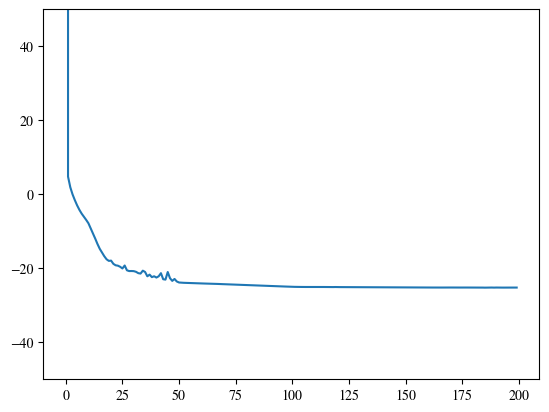

In [17]:
plt.plot(loss_values)
plt.ylim(-50,50)

In [18]:
f_test, ferr_test, specz_test = photoz_archive.get_testing_data()

In [19]:
f_test = torch.Tensor(f_test)
ferr_test = torch.Tensor(ferr_test)
specz_test = torch.Tensor(specz_test)

In [24]:
test_samp = 100

cinn = cinn.eval()
condition_100 = torch.tile(f_test[test_samp], (200,1))
redshifts = np.zeros(shape=(2500,200,7))
for ii in range(2500):
    z_test = torch.randn(200, 7)
    redshift, _ = cinn(z_test.to(device),condition_100.to(device), rev=True)
    redshifts[ii,:] = redshift.detach().cpu().numpy()
redshifts = redshifts.reshape(2500*200,7)   

In [35]:
target_c = np.c_[f_test,specz_test]

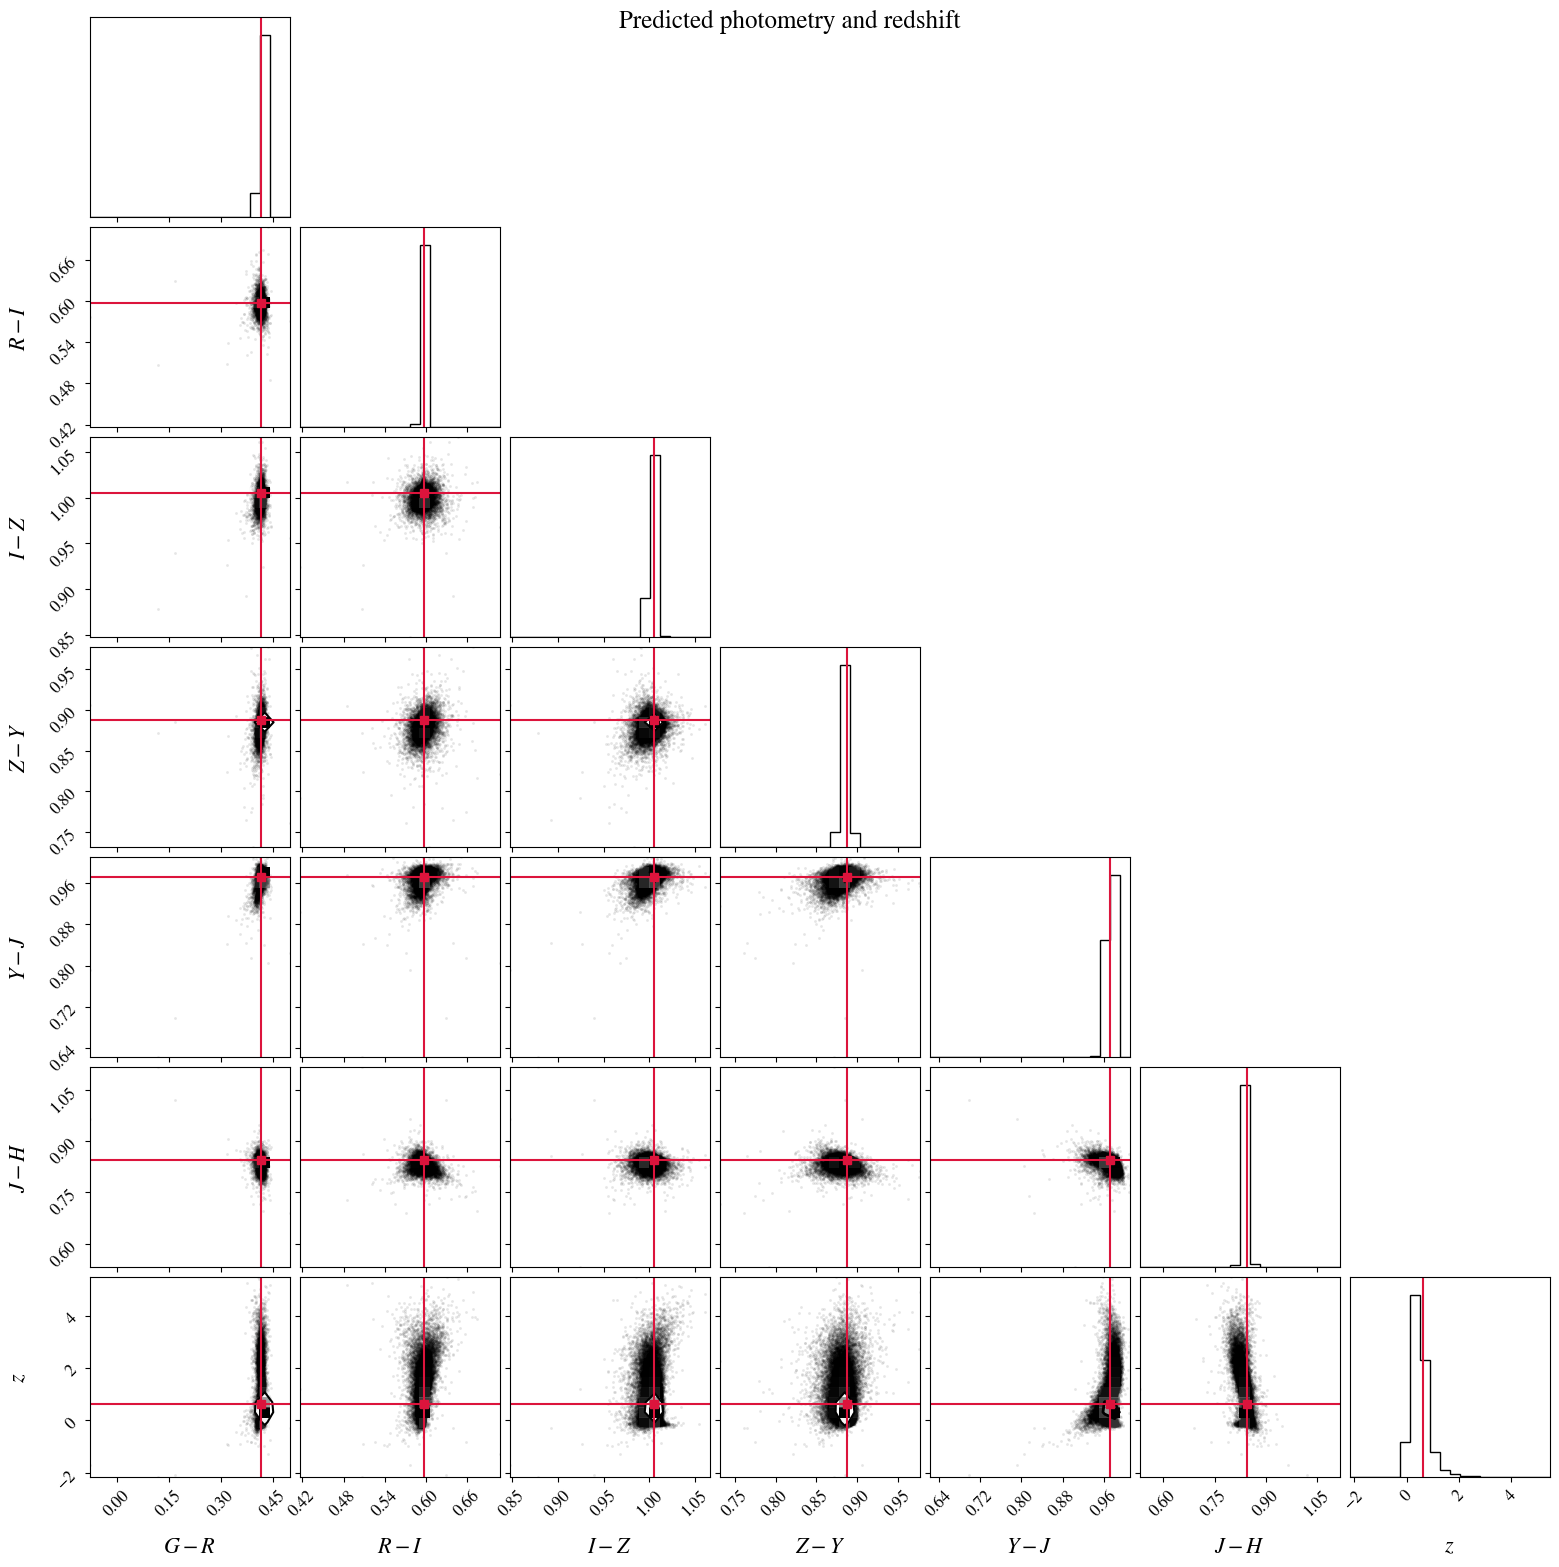

In [36]:
corner_plot = corner.corner(redshifts, 
              labels=['$G-R$','$R-I$','$I-Z$','$Z-Y$','$Y-J$','$J-H$','$z$'], 
              truths=target_c[test_samp],
              truth_color='crimson')


corner_plot.suptitle(f"Predicted photometry and redshift", fontsize=18)
# Increase the label font size for this plot
for ax in corner_plot.get_axes():
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    ax.xaxis.set_tick_params(labelsize=12)  
    ax.yaxis.set_tick_params(labelsize=12)
plt.show()

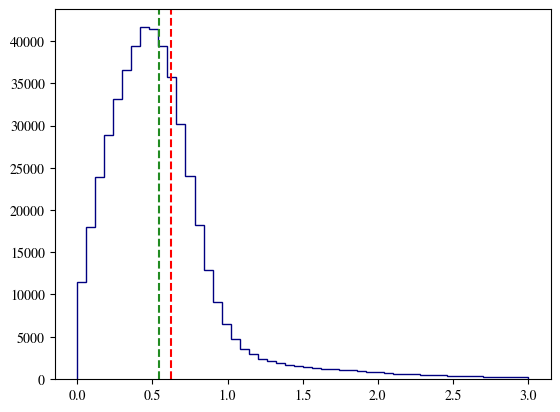

In [30]:
plt.hist(redshifts[:,-1], bins = 50, range =(0,3), histtype='step', color = 'navy')
plt.axvline(specz_test[test_samp], color = 'red', ls='--')
plt.axvline(np.mean(redshifts[:,-1]), color = 'forestgreen', ls='--')

## Systematic testing

In [78]:
cinn = cinn.eval()
bs = 200
Niters = 5
N= len(f_test)
redshifts = np.zeros(shape=(N,Niters,bs,7))
for test_samp in range(N):
    print(test_samp)
    condition_100 = torch.tile(f_test[test_samp], (bs,1))
    
    for ii in range(Niters):
        z_test = torch.randn(bs, 7)
        redshift, _ = cinn(z_test.to(device),condition_100.to(device), rev=True)
        redshifts[test_samp,ii,:,:] = redshift.detach().cpu().numpy()
redshifts = redshifts.reshape(N,Niters*bs,7)   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [85]:
zmean = redshifts[:,:,-1].mean(1)
zerr = redshifts[:,:,-1].std(1)

In [86]:
zmean.shape

(11514,)

In [87]:
VISmag = photoz_archive.get_VIS_mag(photoz_archive.cat_test)

In [88]:
df_test = pd.DataFrame(np.c_[VISmag, specz_test,zmean,zerr], columns = ['VISmag','zs','z','zuncert'])
df_test['zwerr'] = (df_test.z -df_test.zs) / (1+df_test.zs)

In [89]:
df_test

,VISmag,zs,z,zuncert,zwerr
0,23.103798,1.103000,1.510208,0.985641,0.193632
1,22.471019,0.468800,0.568593,0.642112,0.067942
2,21.853940,0.694600,0.729159,0.615262,0.020394
3,22.005561,0.649200,0.764607,0.617034,0.069978
4,22.204387,0.666900,0.853432,0.562838,0.111904
...,...,...,...,...,...
11509,22.449399,0.690462,0.834674,0.464754,0.085309
11510,22.102501,0.915746,1.036027,0.454399,0.062785
11511,22.982543,0.721061,0.796643,0.550158,0.043916
11512,20.037661,0.345100,0.671452,0.542818,0.242623


Text(0, 0.5, '$z$')

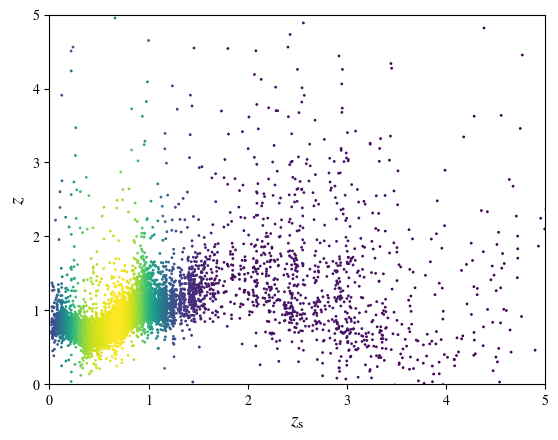

In [91]:
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([specz_test,df_test.z.values])
zd = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
plt.scatter(df_test.zs.values, df_test.z.values,c=zd, s=1)
plt.xlim(0,5)
plt.ylim(0,5)

plt.xlabel(r'$z_{\rm s}$', fontsize = 14)
plt.ylabel('$z$', fontsize = 14)

In [92]:
df_test.to_csv('/data/astro/scratch/lcabayol/Euclid/NNphotozs/results/df_nf0.csv', sep=',')

In [ ]:
from utils import sigma68, nmad, plot_photoz_estimates


In [24]:
np.mean(redshifts[:,-1])

0.5439830251027012

In [23]:
specz_test[test_samp]

tensor(0.6227)

In [25]:
from scipy import stats

In [26]:
stats.mode(redshifts[:,-1])

ModeResult(mode=0.3192215859889984, count=3)

### ENCODER

In [ ]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, layers_size, output_layers, num_layers=1):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList()
        self.selected_out = OrderedDict()
        self.output_layers = output_layers
        self.fhooks = []
        
        for ii in range(len(layers_size)-1):
            self.layers.append(nn.Linear(layers_size[ii], layers_size[ii+1]))
        
        self.encoder = nn.Sequential(*self.layers)

        for i,l in enumerate(list(self.encoder._modules.keys())):
            if i in self.output_layers:
                self.fhooks.append(getattr(self.encoder,l).register_forward_hook(self.forward_hook(l)))

    def forward(self, vector):
        encoded_outputs = self.encoder(vector)
        return encoded_outputs, self.selected_out
                
                
    def forward_hook(self,layer_name):
        def hook(module, inp, out):
            self.selected_out[layer_name] = out
        return hook
        



In [ ]:
from collections import OrderedDict 

In [ ]:
encoder = Encoder(layers_size=[2,2,2],output_layers=[0,1,2])



In [ ]:
num_layers = 2
flows = []
for i in range(num_layers):
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 32, 50, 32, 10, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.nets.MLP([4,2,2]))
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    #flows.append(nf.flows.Permute(num_layers, mode='swap'))
    


In [ ]:
target_dist = nf.distributions.DiagGaussian(2)

In [ ]:
model = nf.NormalizingFlow(target_dist, flows)

for flow in model.flows:
    #print(flow)
    if isinstance(flow, nf.nets.MLP):
        print('f',flow)
    elif isinstance(flow, nf.flows.AffineCouplingBlock):
        print('f',flow)

In [ ]:
optimizer_flow = optim.Adam(model.parameters(), lr=0.001)
optimizer_encoder = optim.Adam(encoder.parameters(), lr=0.001)

loss_count = []
for i in range(100):
    losses = []
    for x,c in loader:
        optimizer_flow.zero_grad()
        optimizer_encoder.zero_grad()
        
        o,lay_out = encoder(c)
        z, logdet = model.forward_and_log_det(x,lay_out)
    
        pz = target_dist.log_prob(z)
        logprob = pz + logdet
        loss = -logprob.mean()
        loss.backward()
        losses.append(loss.item())
        optimizer_flow.step()
        optimizer_encoder.step()

    loss_count.append(np.mean(losses))

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(loss_count, label='loss')
plt.legend()
plt.show()

target_dist = nf.distributions.DiagGaussian(2)

In [ ]:
ys

In [ ]:
list_=[]
model = model.eval()
for i in range(1000):
    cx,cy = 2, 3
    cx,cy= torch.Tensor([cx]).unsqueeze(0), torch.Tensor([cy]).unsqueeze(0)
    c = torch.concat((cx,cy),1)
    o,lay_out = encoder(c)
    s = target_dist.sample(1)
    p = model.inverse(s,lay_out)
    list_.append(p.detach().cpu().numpy()[0])
list_= np.vstack(list_)

In [ ]:
list_

In [ ]:
plt.scatter(list_[:,0],list_[:,1], s=3)
plt.show()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## NORMALIZING FLOW

# Define list of flows
num_layers = 8
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 32 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([4, 512, 512, 512, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(num_layers, mode='swap'))

model = nf.NormalizingFlow(base, flows)

for x,y in loader:
    print(x.shape,y.shape)
    loss = model.forward_kld(y)

In [ ]:
xs, ys = np.random.randint(0,10,8),np.random.randint(0,10,8)
Nclass = 8
Nsamp = 1000
training_sample = torch.zeros(size =(Nclass, Nsamp, 2))
label = torch.zeros(size =(Nclass, Nsamp, 8))
for ii,(x,y) in enumerate(zip(xs,ys)):
    xsamp, ysamp = 0.1*torch.randn(Nsamp,1)+x, 0.1*torch.randn(Nsamp,1)+y
    training_sample[ii] = torch.concat((xsamp,ysamp),1)
    #training_sample[ii,:,2:] =  training_sample[ii,:,2:] + 0.05*torch.randn(Nsamp,6)
    label[ii,:,ii] = 1
    
    plt.scatter(xsamp,ysamp)
    
plt.show()

In [ ]:
training_sample = training_sample.reshape(Nsamp*Nclass,2)
label = label.reshape(Nsamp*Nclass,8)

In [ ]:
dset = TensorDataset(training_sample,label)
from torch.utils.data import random_split
dset_train, dset_val = random_split(dset, [int(0.9*len(dset)), int(0.1*len(dset))])

loader = DataLoader(dset_train, batch_size=100, shuffle=True)
loader_val = DataLoader(dset_val, batch_size=100, shuffle=False)

In [ ]:
# Define flows
K = 4

latent_size = 2
hidden_units = 512
hidden_layers = 3
context_size=8
flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units,
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(2, trainable=False)
    # Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

model = model.to(device)

In [ ]:
# Define target
target = nf.distributions.target.ConditionalDiagGaussian()
context_size = 2


In [ ]:
context.shape

In [ ]:
xx.shape

In [ ]:
label.shape

In [ ]:
x.shape

In [ ]:
loss = model.forward_kld(x, context)

In [ ]:
target = nf.distributions.target.ConditionalDiagGaussian()

In [ ]:
target.log_prob?

In [ ]:
context_plot = torch.cat([torch.tensor([0.3, 0.9]).to(device) + torch.zeros_like(zz), 
                          0.6 * torch.ones_like(zz)], dim=-1)

In [ ]:
# Train model
max_iter = 10
batch_size= 128

loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)


for it in range(max_iter):
    print(it)
    
    for x,y in loader:
        optimizer.zero_grad()
        loss = model.forward_kld(x.to(device), y.to(device))
        loss.backward()
        optimizer.step()
        loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [ ]:
context_plot

In [ ]:
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
plt.contour(xx, yy, p_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

In [ ]:
base = nf.distributions.base.DiagGaussian(2)

In [ ]:
model = nf.NormalizingFlow(base, flows)

In [ ]:
for x,y in loader:
    print(x.shape,y.shape)
    loss = model.forward_kld(y)

In [ ]:
target = nf.distributions.target.TwoMoons()

In [ ]:
target?

In [ ]:
base_dist = torch.distributions.Independent(
  torch.distributions.Normal(torch.zeros(2), torch.ones(2)), 
  1
)
target_dist = torch.distributions.Independent(
  torch.distributions.Normal(torch.zeros(2)+5, torch.ones(2)*0.5),
  1
)

In [ ]:
num_samples = 1000
samples_base = base_dist.sample((num_samples,))
samples_target = target_dist.sample((num_samples,))

# Extract x and y coordinates for plotting
x_values_base = samples_base[:, 0].numpy()
y_values_base = samples_base[:, 1].numpy()

x_values_target = samples_target[:, 0].numpy()
y_values_target = samples_target[:, 1].numpy()

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_values_base, y_values_base, alpha=0.5)
plt.scatter(x_values_target, y_values_target, alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Samples from Base Distribution')
plt.grid(True)
plt.show()

## CREATE NORMALIZING FLOW

##### Normalizing flow with a single transformation

In [ ]:
bijectors = bij.AffineAutoregressive()

In [ ]:
flow = dist.Flow(base_dist, bijectors)

In [ ]:
# Training loop
opt = torch.optim.Adam(flow.parameters(), lr=5e-3)
for idx in range(3001):
    opt.zero_grad()

    # Minimize KL(p || q)
    y = target_dist.sample((1000,))
    loss = -flow.log_prob(y).mean()

    if idx % 500 == 0:
        print('epoch', idx, 'loss', loss)

    loss.backward()
    opt.step()

In [ ]:
dist_y = dist.Flow(base_dist, bijectors)

In [ ]:
num_samples = 1000
samples_pred = dist_y.sample((num_samples,))



In [ ]:
num_samples = 1000
samples_base = base_dist.sample((num_samples,))
samples_target = target_dist.sample((num_samples,))

# Extract x and y coordinates for plotting
x_values_base = samples_base[:, 0].numpy()
y_values_base = samples_base[:, 1].numpy()

x_values_target = samples_target[:, 0].numpy()
y_values_target = samples_target[:, 1].numpy()

# Extract x and y coordinates for plotting
x_values_pred = samples_pred[:, 0].numpy()
y_values_pred = samples_pred[:, 1].numpy()

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_values_base, y_values_base, alpha=0.5)
plt.scatter(x_values_target, y_values_target, alpha=0.5)
plt.scatter(x_values_pred, y_values_pred, alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Samples from Base Distribution')
plt.grid(True)
plt.show()

# SIMPLE EXAMPLE MAPPING FEATRUES INTO PROBABILITY DISTRIBUTIONS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        logp = self.prior.log_prob(z)
        x = self.g(z)
        return x

In [ ]:
nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow = RealNVP(nets, nett, masks, prior)

In [ ]:
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(5001):    
    noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
    loss = -flow.log_prob(torch.from_numpy(noisy_moons)).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

In [ ]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()

In [ ]:
z

In [ ]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')

## WITH NFLOWS

In [ ]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.nn.nets import ResidualNet

In [ ]:
num_layers = 5
base_dist = ConditionalDiagonalNormal(shape=[2], 
                                      context_encoder=nn.Linear(1, 4))

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
                                                          hidden_features=4, 
                                                          context_features=1))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [ ]:
num_iter = 5000
for i in range(num_iter):
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    
    print(x.shape, y.shape)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 500 == 0:
        fig, ax = plt.subplots(1, 2)
        xline = torch.linspace(-1.5, 2.5,100)
        yline = torch.linspace(-.75, 1.25,100)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid0 = flow.log_prob(xyinput, torch.zeros(10000, 1)).exp().reshape(100, 100)
            zgrid1 = flow.log_prob(xyinput, torch.ones(10000, 1)).exp().reshape(100, 100)

        ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy())
        ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()
